# Load and preprocess image

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_317731/481836605.py:21: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:199.)
  image_torch_resized = torch.from_numpy(image_np_resized).permute(2, 0, 1)


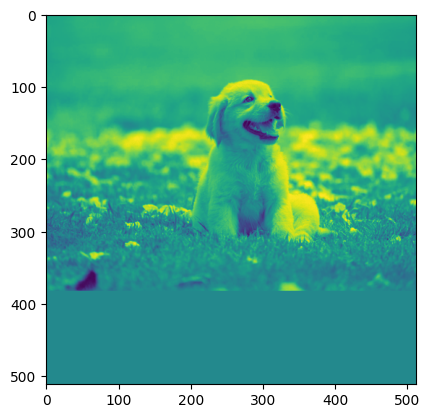

In [1]:
import PIL.Image
import numpy as np
import torch
import matplotlib.pyplot as plt

inference_size = 512
image_mean = torch.tensor([123.675, 116.28, 103.53])[:, None, None]
image_std = torch.tensor([58.395, 57.12, 57.375])[:, None, None]

image_pil = PIL.Image.open("../assets/dog.jpg")
aspect_ratio = image_pil.width / image_pil.height
if aspect_ratio >= 1:
    resize_width = inference_size
    resize_height = int(inference_size / aspect_ratio)
else:
    resize_height = inference_size
    resize_width = int(inference_size * aspect_ratio)

image_pil_resized = image_pil.resize((resize_width, resize_height))
image_np_resized = np.asarray(image_pil_resized)
image_torch_resized = torch.from_numpy(image_np_resized).permute(2, 0, 1)
image_torch_resized_normalized = (image_torch_resized.float() - image_mean) / image_std
image_tensor = torch.zeros((1, 3, inference_size, inference_size))
image_tensor[0, :, :resize_height, :resize_width] = image_torch_resized_normalized


plt.imshow(image_tensor[0,0])
plt.show()

In [2]:
from mobile_sam.modeling.image_encoder_cnn import ImageEncoderCNN


image_encoder_cnn = ImageEncoderCNN()
image_encoder_cnn.load_state_dict(torch.load("../data/models/resnet18/checkpoint.pth")['model'])
image_encoder_trt = image_encoder_cnn.cuda().eval()

In [3]:
import torch2trt

In [21]:
image_encoder_trt = torch2trt.torch2trt(image_encoder_cnn, [torch.randn(1, 3, 512, 512).cuda()], fp16_mode=True, use_onnx=True)

========== Diagnostic Run torch.onnx.export version 1.14.0a0+44dac51 ===========
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



# Load Mask Decoder

In [4]:
import tensorrt as trt
from torch2trt import TRTModule

with trt.Logger() as logger, trt.Runtime(logger) as runtime:
    with open("../data/mobile_sam_mask_decoder.engine", 'rb') as f:
        engine_bytes = f.read()
    engine = runtime.deserialize_cuda_engine(engine_bytes)

input_names = [
    "image_embeddings",
    "point_coords",
    "point_labels",
    "mask_input",
    "has_mask_input"
]

output_names = [
    "iou_predictions",
    "low_res_masks"
]


mask_decoder_trt = TRTModule(
    engine=engine,
    input_names=input_names,
    output_names=output_names
)

# Run Inference

In [5]:
import time

In [6]:
image_tensor = image_tensor.float().cuda()
image_embeddings = image_encoder_trt(image_tensor)

torch.cuda.current_stream().synchronize()
t0 = time.monotonic()
for i in range(50):
    image_embeddings = image_encoder_trt(image_tensor)

torch.cuda.current_stream().synchronize()
t1 = time.monotonic()

print(50 / (t1 - t0))

292.41856046356907


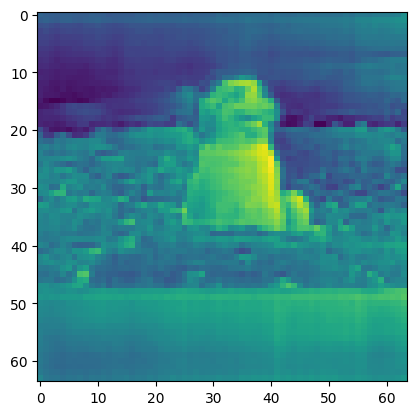

In [7]:
plt.imshow(image_embeddings[0, 0].detach().cpu())
plt.show()

In [8]:
image_1024 = image_pil.resize((1024, int(1024*image_pil.height/image_pil.width)))

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

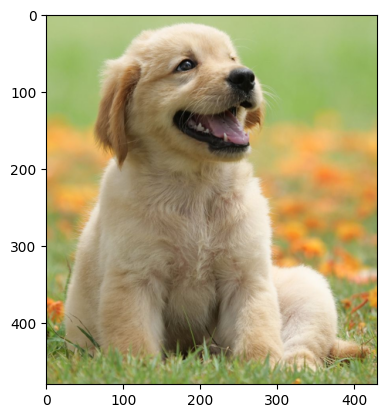

In [9]:
box = [380, 170, 810, 650]
plt.imshow(np.asarray(image_1024)[box[1]:box[3], box[0]:box[2]])
plt.plot

In [28]:

point = [550, 400]
points = [
    [box[0], box[1]],
    [box[2], box[3]]
]
image_point_coords = torch.tensor([points]).float().cuda()
image_point_labels = torch.tensor([[2, 3]]).float().cuda()
mask_input = torch.zeros(1, 1, 256, 256).float().cuda()
has_mask_input = torch.tensor([0]).float().cuda()
# orig_im_size = torch.tensor([image_pil.height, image_pil.width], dtype=torch.int32)

In [29]:
import time

In [30]:

torch.cuda.current_stream().synchronize()
t0 = time.monotonic()
for i in range(50):
    iou_predictions, low_res_masks = mask_decoder_trt(
        image_embeddings,
        image_point_coords,
        image_point_labels,
        mask_input,
        has_mask_input
    )

torch.cuda.current_stream().synchronize()
t1 = time.monotonic()

print(50 / (t1 - t0))

508.0837937179327


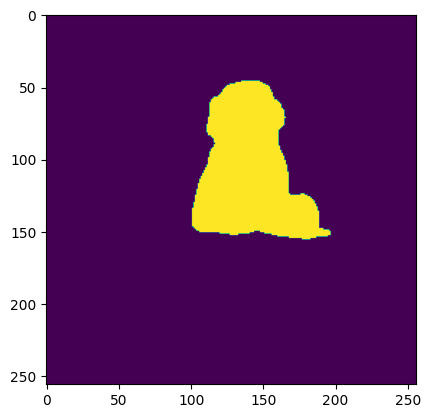

In [31]:
plt.imshow(low_res_masks[0, 2].detach().cpu() > 0)
plt.show()

# Optimize encoder w torch2trt

In [11]:

from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
mobile_sam = sam_model_registry["vit_t"](checkpoint="../weights/mobile_sam.pt")
mobile_sam.to(device="cuda")
mobile_sam = mobile_sam.eval()

In [4]:
data = torch.randn(1, 3, 1024, 1024).cuda()

In [5]:
from torch2trt import torch2trt

In [6]:
model_trt = torch2trt(mobile_sam.image_encoder, [data], fp16_mode=True, use_onnx=True)

/workspace/mobile_sam/modeling/tiny_vit_sam.py:338: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert L == H * W, "input feature has wrong size"
/workspace/mobile_sam/modeling/tiny_vit_sam.py:136: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  B = len(x)
/usr/local/lib/python3.8/dist-packages/torch/onnx/_internal/jit_utils.py:302: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_infe

========== Diagnostic Run torch.onnx.export version 1.14.0a0+44dac51 ===========
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

[W] colored module is not installed, will not use colors when logging. To enable colors, please install the colored module: python3 -m pip install colored
[W] Inference failed. You may want to try enabling partitioning to see better results. Note: Error was:
No module named 'onnxruntime'
[07/07/2023-22:27:03] [TRT] [E] 4: [optimizer.cpp::computeCosts::3726] Error Code 4: Internal Error (Could not find any implementation for node {ForeignNode[onnx::MatMul_2670 + (Unnamed Layer* 160) [Shuffle].../module/layers.1/blocks.0/Transpose_3 + /module/layers.1/blocks.0/Reshape_8]} due to insufficient workspace. See verbose log for requested sizes.)


In [15]:
features_orig.min()

tensor(-0.6439, device='cuda:0')

In [12]:
with torch.no_grad():
    features_orig = mobile_sam.image_encoder(image_tensor)

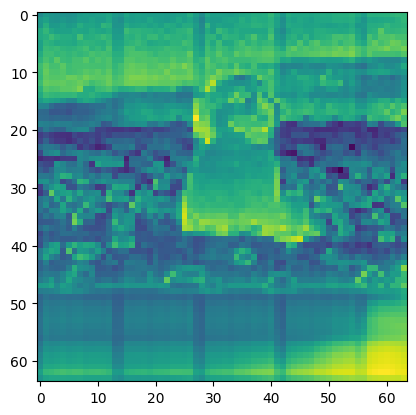

In [8]:
plt.imshow(features_orig[0, 2].detach().cpu())